In [ ]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import train_test_split
import numpy as np
from drfp import DrfpEncoder

# Data preparation

In [ ]:
# The dataset obtained in the 2_ord_processing.ipynb notebook
df = pd.read_csv('ord_to_add.tsv', sep='\t')
df.head()

,standard_reaction_smiles,yields
0,Cl.[CH3]O[CH2][C@H]([NH2])C1=[CH][CH]=[CH][CH]...,22.1
1,Cl.[CH3]O[CH2][C@H]([NH2])C1=[CH][CH]=[CH][CH]...,57.3
2,CC(=O)[O-].[CH3]C(=O)C1=[CH]C2=[CH][CH]=[CH][C...,89.0
3,CO.[CH]1=[CH][CH]=C(OC2=[CH][CH]=C(C3=[CH][CH2...,66.0
4,Cl.Cl[CH2][CH2][NH][CH2][CH2]Cl.[NH2]C1=[CH][C...,75.0


In [ ]:
def split_reaction(reaction_smiles):
  
  """This function splits reaction SMILES into reactants, reagents and product."""
  
  d = dict()
  if '>>' in reaction_smiles:
    react_list = reaction_smiles.split('>>')
    d['reactants'] = react_list[0]
    d['products'] = react_list[1]
  else:
    react_list = reaction_smiles.split('>')
    d['reactants'] = react_list[0]
    d['reagents'] = react_list[1]
    d['products'] = react_list[2]
  return d

# Split reaction SMILES into dictionaries
df['ReactionDict'] = df.standard_reaction_smiles.apply(split_reaction)

# Split dictionaries into separate columns
df['reactants'] = df.ReactionDict.apply(lambda x: x['reactants'])
df['reagents'] = df.ReactionDict.apply(lambda x: x['reagents'] if 'reagents' in x.keys() else None)
df['products'] = df.ReactionDict.apply(lambda x: x['products'])

# Split strings into lists
df['reactants'] = df.reactants.apply(lambda x: x.split('.'))
df['reagents'] = df.reagents.apply(lambda x: x.split('.') if x!=None else None)
df['products'] = df.products.apply(lambda x: x.split('.'))

# Drop reactions with >2 reactants
df['Len'] = df.reactants.apply(lambda x: len(x))
df = df[df.Len.isin([1, 2])]

In [ ]:
# Drop unnecessary columns
df = df[['standard_reaction_smiles', 'yields']]
df.reset_index(drop=True, inplace=True)
df.head()

,standard_reaction_smiles,yields
0,CO.[CH]1=[CH][CH]=C(OC2=[CH][CH]=C(C3=[CH][CH2...,66.0
1,[CH3]C([CH3])([CH3])C1=[CH][CH]=C([CH2]O[NH2])...,80.0
2,CC1=CC=C(S(=O)(=O)O[CH]2[CH2][CH2]C3([CH2][CH2...,70.0
3,[CH3]C1=N[CH]=[CH]C(Cl)=C1Cl.[CH3][CH2]O[CH2][...,28.0
4,[CH3]C1([CH3])[CH2]OC2([CH2][CH2][CH]([OH])[CH...,75.0


In [ ]:
df.shape

(21133, 2)

In [ ]:
def get_drfp(reaction_smiles, n_folded_length=2048, radius=2):
  
  """This function converts reaction SMILES into differential reaction fingerprints (DRFP)."""
  
  fp = DrfpEncoder.encode(reaction_smiles, n_folded_length=n_folded_length, radius=radius)
  return fp[0]

In [ ]:
# Convert reaction SMILES into DRFPs
X = [get_drfp(smi) for smi in df.standard_reaction_smiles]

# Dimensionality reduction with UMAP

In [ ]:
emb = umap.UMAP(metric='sokalmichener').fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(emb[:, 0], emb[:, 1], cmap='viridis', s=5)
plt.show()

In [ ]:
np.save('ord_embeddings_sokalmichener.npy', emb)

# Clustering with HDBSCAN

In [ ]:
emb = np.load('ord_embeddings_sokalmichener.npy')

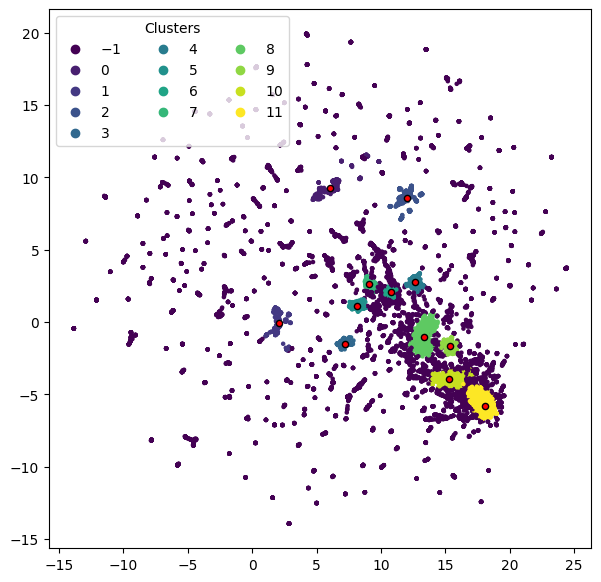

In [ ]:
hdb = HDBSCAN(min_cluster_size=225, max_cluster_size=10000, store_centers='centroid').fit(emb)
fig, ax = plt.subplots(figsize=(7, 7))
sc = ax.scatter(emb[:, 0], emb[:, 1], c=hdb.labels_, s=5)
cent = ax.scatter(hdb.centroids_[:, 0], hdb.centroids_[:, 1], color='red', edgecolors='black', s=20)
ax.legend(*sc.legend_elements(), title='Clusters', ncols=3)
#plt.savefig('ord_clustering.jpg', format='jpg', dpi=500, bbox_inches='tight')
plt.show()

# ORD-R dataset

In [ ]:
# Create dataset with SMILES, UMAP embeddings, clusters and yields
dfc = pd.DataFrame({'smiles': df.standard_reaction_smiles, 'x': emb[:, 0], 'y': emb[:, 1], 'cluster': hdb.labels_, 'yields': df.yields})
dfc.cluster.value_counts()

cluster
-1     11848
 11     2585
 8      1576
 10     1070
 0       644
 4       566
 5       558
 7       458
 2       435
 9       428
 1       396
 6       332
 3       237
Name: count, dtype: int64

In [ ]:
dfc.shape

(21133, 5)

In [ ]:
# Randomly sample 5000 reactions
df_rand = dfc.sample(n=5000, random_state=42)
df_rand.reset_index(drop=True, inplace=True)

# Sample 100 reactions for the test subset
X_train, X_test, y_train, y_test = train_test_split(df_rand.smiles,
                                                    df_rand.yields,
                                                    test_size=100/5000,
                                                    random_state=42)

In [ ]:
y_test.shape

(100,)

In [ ]:
# Randomly sample 300 reactions for the validation subset
dfc_left = pd.concat([dfc, df_rand]).drop_duplicates(keep=False)
df_val = dfc_left.sample(n=300, random_state=42)
df_val

In [ ]:
# Add the split column
for idx in df_rand.index:
  if idx in y_test.index:
    df_rand.loc[idx, 'split'] = 'test'
  else:
    df_rand.loc[idx, 'split'] = 'train'
df_rand.split.value_counts()

split
train    4900
test      100
Name: count, dtype: int64

In [ ]:
# Add the split column
df_val['split'] = 'val'
df_val.head()

,smiles,x,y,cluster,yields,split
10364,C#C[CH2]N1C(=O)C2=[CH][CH]=[CH][CH]=C2N=C1[CH3...,19.046030,-5.602465,-1,57.0,val
2916,N#CC1=C(C#N)C(=O)C(Cl)=C(Cl)C1=O.[CH3][C@@H]1[...,14.458782,-4.167707,10,5.0,val
17767,O=[CH][CH2][CH2]C1=C(Cl)[CH]=[CH][CH]=[CH]1.[C...,15.889690,-3.608427,10,88.0,val
9412,COC1CCCC1.[CH3]C1=[CH]C([CH3])=C(C([CH3])([CH3...,12.385020,2.833223,4,66.8,val
7957,[CH3]C(=O)C1=[CH]C(Cl)=C([CH2]O[CH2]C(F)(F)F)N...,-9.059423,-0.893283,-1,82.0,val


In [ ]:
# Concatenate train, test and validation subsets
df_rand = pd.concat([df_rand, df_val])
df_rand

,smiles,x,y,cluster,yields,split
0,[CH3][CH]([CH3])OC(=O)Cl.[NH2][NH]C1=N[NH]C2=[...,17.848198,-5.599133,11,68.0,train
1,COC(=O)O[CH3].[CH3]C1=C([N+](=O)[O-])[CH]=C([N...,5.619365,8.969636,0,63.0,train
2,[CH3][CH2]C(=O)N([CH3])[CH]1[CH2][CH2]N(CC2=CC...,9.980985,-0.281226,-1,60.0,train
3,CCOC(=O)[NH]C1=NC2=[CH]C(Cl)=[CH][CH]=C2N=C1O[...,-11.428165,8.657166,-1,80.0,train
4,FC1=[CH][CH]=C(C2=[CH][CH]=C3N=[CH]N=C(Cl)C3=[...,16.011898,-4.233834,10,68.0,train
...,...,...,...,...,...,...
9936,BrC1=[CH]C2=[CH][CH]=[CH][CH]=C2[CH]=[CH]1.[CH...,13.288330,2.518614,4,66.0,val
8265,C#CC1=[CH][CH]=C([CH2][CH2][CH3])[CH]=[CH]1.[C...,18.057405,-5.318089,11,5.0,val
12902,OC(=O)C1=[CH]N=[CH]C(C2=NOC(C(F)(F)F)=N2)=[CH]...,9.373596,-2.573192,-1,10.0,val
11136,[CH3]OC1=C([N+](=O)[O-])[CH]=C([CH2]S(=O)(=O)[...,21.442614,3.946769,-1,47.0,val


In [ ]:
# Convert yield values into binary classification labels
df_rand_1 = df_rand[['smiles', 'yields', 'split']]
df_rand_1['high_yielding'] = df_rand_1.yields.apply(lambda x: 0 if x < 70 else 1)
df_rand_1['not_high_yielding'] = df_rand_1.yields.apply(lambda x: 0 if x >= 70 else 1)
df_rand_1.drop(columns=['yields'], inplace=True)
df_rand_1.head()

,smiles,yields,split
0,[CH3][CH]([CH3])OC(=O)Cl.[NH2][NH]C1=N[NH]C2=[...,68.0,train
1,COC(=O)O[CH3].[CH3]C1=C([N+](=O)[O-])[CH]=C([N...,63.0,train
2,[CH3][CH2]C(=O)N([CH3])[CH]1[CH2][CH2]N(CC2=CC...,60.0,train
3,CCOC(=O)[NH]C1=NC2=[CH]C(Cl)=[CH][CH]=C2N=C1O[...,80.0,train
4,FC1=[CH][CH]=C(C2=[CH][CH]=C3N=[CH]N=C(Cl)C3=[...,68.0,train


In [ ]:
df_rand_1.to_csv('ORD_R_smiles.csv', index=False)

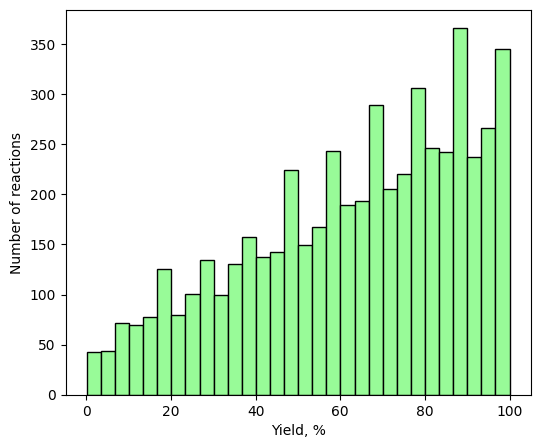

In [ ]:
# Distribution of yield values in the ORD-R dataset
fig, ax = plt.subplots(figsize=(6, 5))
plt.hist(df_rand_1.yields, bins=30, color='palegreen', edgecolor='black')
plt.xlabel('Yield, %')
plt.ylabel('Number of reactions')
#plt.savefig('ord_yields.jpg', format='jpg', dpi=500, bbox_inches='tight')
plt.show()

# ORD-C dataset

In [ ]:
# Drop the -1 (noise) cluster
df_clusters = dfc[dfc.cluster != -1]
df_clusters.reset_index(drop=True, inplace=True)
df_clusters.cluster.value_counts()

cluster
11    2585
8     1576
10    1070
0      644
4      566
5      558
7      458
2      435
9      428
1      396
6      332
3      237
Name: count, dtype: int64

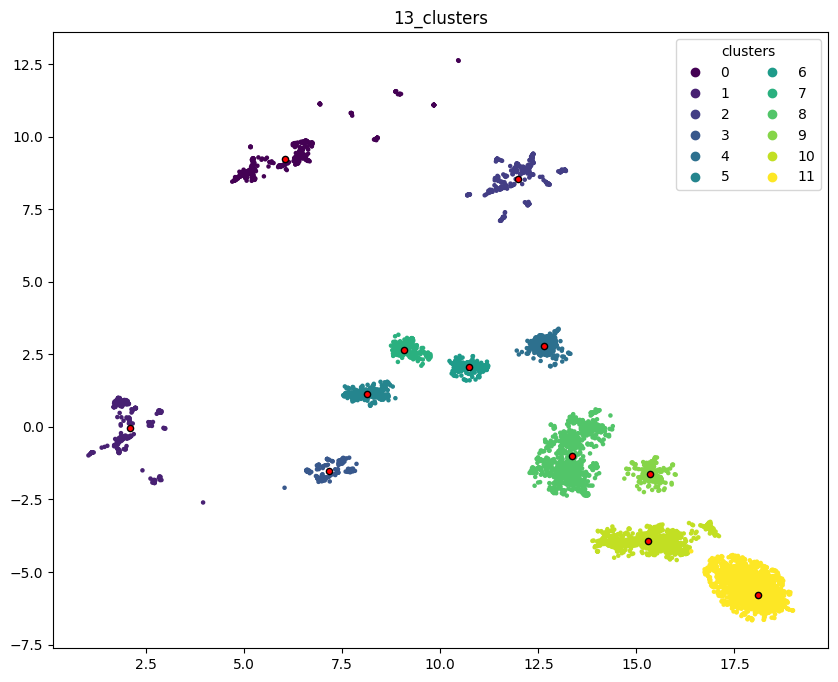

In [ ]:
# Visualize clusters
emb_x = df_clusters.x.tolist()
emb_y = df_clusters.y.tolist()
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(emb_x, emb_y, c=df_clusters.cluster.tolist(), s=5)
cent = ax.scatter(hdb.centroids_[:, 0], hdb.centroids_[:, 1], color='red', edgecolors='black', s=20)
ax.legend(*sc.legend_elements(), title='clusters', ncols=2)
plt.title(f'{len(set(hdb.labels_))}_clusters')
plt.show()

In [ ]:
# Calculate cluster centroids
centroids = dict(zip([i for i in range(0, 12)], hdb.centroids_))
centroids

{0: array([6.03524566, 9.24170395]),
 1: array([ 2.07494458, -0.03167321]),
 2: array([11.98342777,  8.53877457]),
 3: array([ 7.16972461, -1.50553989]),
 4: array([12.63730728,  2.79489633]),
 5: array([8.13847997, 1.14115873]),
 6: array([10.74247875,  2.07577009]),
 7: array([9.06364084, 2.66210361]),
 8: array([13.3692216 , -1.00711502]),
 9: array([15.35852829, -1.63230231]),
 10: array([15.29044657, -3.9414623 ]),
 11: array([18.09083731, -5.7789842 ])}

In [ ]:
df_clusters['centroid_x'] = df_clusters.cluster.apply(lambda x: centroids[x][0] if x!=-1 else None)
df_clusters['centroid_y'] = df_clusters.cluster.apply(lambda x: centroids[x][1] if x!=-1 else None)
df_clusters

<ipython-input-39-3835bed54b99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['centroid_x'] = df_clusters.cluster.apply(lambda x: centroids[x][0] if x!=-1 else None)
<ipython-input-39-3835bed54b99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['centroid_y'] = df_clusters.cluster.apply(lambda x: centroids[x][1] if x!=-1 else None)


,smiles,x,y,cluster,yields,centroid_x,centroid_y
0,CO.[CH]1=[CH][CH]=C(OC2=[CH][CH]=C(C3=[CH][CH2...,13.307993,-1.182416,8,66.0,13.369222,-1.007115
1,[CH3]C([CH3])([CH3])C1=[CH][CH]=C([CH2]O[NH2])...,13.942036,-0.072478,8,80.0,13.369222,-1.007115
2,CC1=CC=C(S(=O)(=O)O[CH]2[CH2][CH2]C3([CH2][CH2...,15.196901,-1.314770,9,70.0,15.358528,-1.632302
3,[CH3]C1=N[CH]=[CH]C(Cl)=C1Cl.[CH3][CH2]O[CH2][...,14.198439,-0.141745,8,28.0,13.369222,-1.007115
4,[CH3][CH2]C1=N[CH]=[CH]C(Cl)=C1Cl.[NH2]O[CH2]C...,13.930901,-0.067343,8,99.0,13.369222,-1.007115
...,...,...,...,...,...,...,...
9280,C[Sn](C)(C)[CH3].[CH3][CH2]OC1=[CH][CH]=C(C2=N...,8.450691,0.967486,5,81.7,8.138480,1.141159
9281,CC[OH].[CH3]O[CH2]OC1=[CH]C2=C([CH]=C1[N+](=O)...,6.466897,9.303082,0,98.0,6.035246,9.241704
9282,ClC1=N[CH]=C(Br)C(Cl)=N1.N>C1CCOC1>[NH2]C1=NC(...,12.600676,2.907850,4,92.0,12.637307,2.794896
9283,OC=O.[CH3]C1=C2C(=O)N([CH2]C3=[CH][CH]=C(OC(F)...,13.605061,-1.931209,8,30.0,13.369222,-1.007115


In [ ]:
def dictance_to_centroid(dot_x, dot_y, centroid_x, centroid_y):
    
    """This function calculates the euclidean distance between the point and the cluster centroid."""
    
    dot = np.array((dot_x, dot_y))
    centroid = np.array((centroid_x, centroid_y))
    return np.linalg.norm(dot - centroid)

In [ ]:
# Calculate the distance to the centroid for each point
for idx in df_clusters.index:
    dot_x = df_clusters.loc[idx, 'x']
    dot_y = df_clusters.loc[idx, 'y']
    centroid_x = df_clusters.loc[idx, 'centroid_x']
    centroid_y = df_clusters.loc[idx, 'centroid_y']
    distance = dictance_to_centroid(dot_x, dot_y, centroid_x, centroid_y)
    df_clusters.loc[idx, 'distance'] = distance
df_clusters

<ipython-input-41-3d3f091fdab6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters.loc[idx, 'distance'] = distance


,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance
0,CO.[CH]1=[CH][CH]=C(OC2=[CH][CH]=C(C3=[CH][CH2...,13.307993,-1.182416,8,66.0,13.369222,-1.007115,0.185687
1,[CH3]C([CH3])([CH3])C1=[CH][CH]=C([CH2]O[NH2])...,13.942036,-0.072478,8,80.0,13.369222,-1.007115,1.096204
2,CC1=CC=C(S(=O)(=O)O[CH]2[CH2][CH2]C3([CH2][CH2...,15.196901,-1.314770,9,70.0,15.358528,-1.632302,0.356300
3,[CH3]C1=N[CH]=[CH]C(Cl)=C1Cl.[CH3][CH2]O[CH2][...,14.198439,-0.141745,8,28.0,13.369222,-1.007115,1.198527
4,[CH3][CH2]C1=N[CH]=[CH]C(Cl)=C1Cl.[NH2]O[CH2]C...,13.930901,-0.067343,8,99.0,13.369222,-1.007115,1.094831
...,...,...,...,...,...,...,...,...
9280,C[Sn](C)(C)[CH3].[CH3][CH2]OC1=[CH][CH]=C(C2=N...,8.450691,0.967486,5,81.7,8.138480,1.141159,0.357265
9281,CC[OH].[CH3]O[CH2]OC1=[CH]C2=C([CH]=C1[N+](=O)...,6.466897,9.303082,0,98.0,6.035246,9.241704,0.435993
9282,ClC1=N[CH]=C(Br)C(Cl)=N1.N>C1CCOC1>[NH2]C1=NC(...,12.600676,2.907850,4,92.0,12.637307,2.794896,0.118745
9283,OC=O.[CH3]C1=C2C(=O)N([CH2]C3=[CH][CH]=C(OC(F)...,13.605061,-1.931209,8,30.0,13.369222,-1.007115,0.953714


In [ ]:
# Sort reactions by distance within each cluster
df_clusters = df_clusters.sort_values(by=['cluster', 'distance'])
df_clusters

,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance
4546,O=C([OH])C1=C2[NH][CH2][CH2]OC2=[CH]C([N+](=O)...,6.034244,9.108062,0,5.3,6.035246,9.241704,0.133646
1591,CC[CH2]OC1=[CH]C(C=O)=CC([N+](=O)[O-])=C1O.[CH...,6.141709,9.118637,0,89.0,6.035246,9.241704,0.162727
8642,COC1=C(N2CCN(CCN(C(=O)[CH]3[CH2][CH2][CH2][CH2...,6.110957,9.076726,0,67.0,6.035246,9.241704,0.181521
4181,CC1=C(NC=O)C=C(C(O)=O)C([N+](=O)[O-])=C1.[CH3]...,6.025718,9.046123,0,98.0,6.035246,9.241704,0.195813
838,O=C(N1C=CN=C1)N1C=CN=C1.O=[N+]([O-])C1=C(F)[CH...,6.047338,9.024677,0,65.8,6.035246,9.241704,0.217363
...,...,...,...,...,...,...,...,...
3023,[CH3]OC1=C([CH]=O)[CH]=[CH]C2=C1O[CH2]O2.[CH3]...,16.872005,-4.614253,11,100.0,18.090837,-5.778984,1.685868
9007,[CH3][CH]([CH3])[CH]1[CH2][CH2][CH2][CH]([CH](...,16.925148,-4.556344,11,93.0,18.090837,-5.778984,1.689284
9008,[CH3][CH2][CH]1[CH2][CH2][CH2][CH]([CH2][CH3])...,16.890463,-4.582265,11,96.0,18.090837,-5.778984,1.695003
4894,[CH3]C1([CH3])OB(C2=C3[CH2][C@H](N(CC4=CC=CC=C...,16.932003,-4.521629,11,67.0,18.090837,-5.778984,1.709923


In [ ]:
# Dictionary {cluster label: number of reactions in a cluster}
clusters_dict = dict(zip(df_clusters.cluster.value_counts().keys(), df_clusters.cluster.value_counts().values))
clusters_dict

{11: 2585,
 8: 1576,
 10: 1070,
 0: 644,
 4: 566,
 5: 558,
 7: 458,
 2: 435,
 9: 428,
 1: 396,
 6: 332,
 3: 237}

In [ ]:
# Select closest to the centroid reactions from each cluster proportionally to the size of the cluster
frames = []
for cltr, n in clusters_dict.items():
  dfx = df_clusters[df_clusters.cluster==cltr]
  dfx.reset_index(drop=True, inplace=True)
  dfx = dfx.loc[:int(np.round(7000*n/9285, 0))]
  frames.append(dfx)

In [ ]:
df_new = pd.concat(frames)

In [ ]:
df_clusters_left = pd.concat([df_clusters, df_new]).drop_duplicates(keep=False)
df_clusters_left

,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance
1729,[H][H].[NH2]C1=NC2=C([CH]=C([N+](=O)[O-])[CH]=...,4.993333,8.691583,0,96.0,6.035246,9.241704,1.178226
6366,[CH3]C1([CH3])[CH2][CH]([NH]C(=O)C2=[CH]C([N+]...,4.949310,8.778505,0,79.6,6.035246,9.241704,1.180597
5303,N#CC1=C(S(=O)(=O)[NH]C2=[CH]C3=C([CH]=[CH]2)[C...,4.984673,8.699149,0,0.1,6.035246,9.241704,1.182400
2338,[CH3]C1=[CH]N(C2=[CH]C([N+](=O)[O-])=[CH]C(C(F...,4.954275,8.760743,0,85.8,6.035246,9.241704,1.183140
5200,[CH3][CH2][CH2][CH2]C1=NN(C2=C(Cl)[CH]=[CH]C([...,4.980111,8.700800,0,57.0,6.035246,9.241704,1.185701
...,...,...,...,...,...,...,...,...
3023,[CH3]OC1=C([CH]=O)[CH]=[CH]C2=C1O[CH2]O2.[CH3]...,16.872005,-4.614253,11,100.0,18.090837,-5.778984,1.685868
9007,[CH3][CH]([CH3])[CH]1[CH2][CH2][CH2][CH]([CH](...,16.925148,-4.556344,11,93.0,18.090837,-5.778984,1.689284
9008,[CH3][CH2][CH]1[CH2][CH2][CH2][CH]([CH2][CH3])...,16.890463,-4.582265,11,96.0,18.090837,-5.778984,1.695003
4894,[CH3]C1([CH3])OB(C2=C3[CH2][C@H](N(CC4=CC=CC=C...,16.932003,-4.521629,11,67.0,18.090837,-5.778984,1.709923


In [ ]:
df_new.reset_index(drop=True, inplace=True)

In [ ]:
# Sample 100 reactions for the test set
X_train, X_test, y_train, y_test = train_test_split(df_new.x,
                                                    df_new.cluster,
                                                    test_size=100/7014,
                                                    random_state=42,
                                                    stratify=df_new.cluster)
y_test.shape

(100,)

In [ ]:
# Add the split column
for idx in df_new.index:
  if idx in y_test.index:
    df_new.loc[idx, 'split'] = 'test'
  else:
    df_new.loc[idx, 'split'] = 'train'
df_new.split.value_counts()

split
train    6914
test      100
Name: count, dtype: int64

In [ ]:
# Sample 300 reactions for the validation set
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_clusters_left.x,
                                                    df_clusters_left.cluster,
                                                    test_size=300/df_clusters_left.shape[0],
                                                    random_state=42,
                                                    stratify=df_clusters_left.cluster)
y_test1.shape

(300,)

In [ ]:
# Add the split column
for idx in df_clusters_left.index:
  if idx in y_test1.index:
    df_clusters_left.loc[idx, 'split'] = 'val'
  else:
    pass
df_clusters_left.split.value_counts()

split
val    300
Name: count, dtype: int64

In [ ]:
df_new_val = df_clusters_left[df_clusters_left.split=='val']
df_new_val.shape

(300, 9)

In [ ]:
df_new_val.reset_index(drop=True, inplace=True)
df_new_val

,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance,split
0,[CH3]C1([CH3])[CH2][CH]([NH]C(=O)C2=[CH]C([N+]...,4.949310,8.778505,0,79.6,6.035246,9.241704,1.180597,val
1,[CH3]C([CH3])([CH3])OC(=O)N1[CH2][CH2][C@@H](O...,4.944973,8.670489,0,82.0,6.035246,9.241704,1.230846,val
2,O=[N+]([O-])C1=[CH]C(Cl)=C(O[CH2]C2=[CH]C(F)=[...,4.926706,8.658625,0,100.0,6.035246,9.241704,1.252534,val
3,[CH3][C@@H]([NH]C1=N[CH]=NC2=C(C([NH2])=O)[CH]...,4.846968,8.584196,0,93.0,6.035246,9.241704,1.358058,val
4,[CH3]OC(=O)C1=C([CH3])[NH]C(=O)N(C(=O)O[CH3])[...,4.797368,8.538994,0,97.0,6.035246,9.241704,1.423427,val
...,...,...,...,...,...,...,...,...,...
295,[CH]1=[CH][CH]=[CH][CH]=[CH]1.[H][H]>[Pd]>[CH]...,17.033022,-4.607830,11,79.0,18.090837,-5.778984,1.578156,val
296,[CH3][CH2]OC(=O)C1=NC2=C(C#N)[CH]=NN2C(Cl)=C1[...,16.808357,-4.856173,11,95.6,18.090837,-5.778984,1.579980,val
297,[CH3]C([CH3])([CH3])[CH]1[CH2][CH2][CH2][CH]([...,17.037306,-4.578576,11,95.0,18.090837,-5.778984,1.597157,val
298,CCOC(=O)Cl.CCO[CH](O[CH2][CH3])[CH]1[CH2][CH2]...,17.013680,-4.578344,11,90.5,18.090837,-5.778984,1.613012,val


In [ ]:
# Concatenate train, test and validation subsets
df_new = pd.concat([df_new, df_new_val])
df_new.reset_index(drop=True, inplace=True)

In [ ]:
df_new.split.value_counts()

split
train    6914
val       300
test      100
Name: count, dtype: int64

In [ ]:
# Drop unnecessary columns
df_new_1 = df_new[['smiles', 'yields', 'split']]
df_new_1.head()

,smiles,yields,split
0,C1=CO[CH]=C1.COC1=C(O[CH3])O[CH2][CH2]1>>[CH3]...,0.9,train
1,C=O.[CH3][CH2]C1=N[CH2][CH2]O1>O>[CH3][CH]([CH...,96.0,train
2,O=C(Cl)[CH2][CH2][CH2]Cl.[NH2][CH2]/C=C\[CH2]O...,73.0,train
3,Br[CH2][CH2][CH2][CH2][CH2][CH2]Br.[OH][CH2]C1...,36.0,train
4,N#C[CH2]C1=[CH][CH]=[CH][CH]=[CH]1.O=[CH]C1=[C...,53.0,train


In [ ]:
# Convert yields to binary classification labels
df_new_1['high_yielding'] = df_new_1.yields.apply(lambda x: 0 if x < 70 else 1)
df_new_1['not_high_yielding'] = df_new_1.yields.apply(lambda x: 0 if x >= 70 else 1)
df_new_1.drop(columns=['yields'], inplace=True)
df_new_1

<ipython-input-59-40c64a489752>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_1['high_yielding'] = df_new_1.yields.apply(lambda x: 0 if x < 70 else 1)
<ipython-input-59-40c64a489752>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_1['not_high_yielding'] = df_new_1.yields.apply(lambda x: 0 if x >= 70 else 1)
<ipython-input-59-40c64a489752>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

,smiles,split,high_yielding,not_high_yielding
0,C1=CO[CH]=C1.COC1=C(O[CH3])O[CH2][CH2]1>>[CH3]...,train,0,1
1,C=O.[CH3][CH2]C1=N[CH2][CH2]O1>O>[CH3][CH]([CH...,train,1,0
2,O=C(Cl)[CH2][CH2][CH2]Cl.[NH2][CH2]/C=C\[CH2]O...,train,1,0
3,Br[CH2][CH2][CH2][CH2][CH2][CH2]Br.[OH][CH2]C1...,train,0,1
4,N#C[CH2]C1=[CH][CH]=[CH][CH]=[CH]1.O=[CH]C1=[C...,train,0,1
...,...,...,...,...
7309,[CH]1=[CH][CH]=[CH][CH]=[CH]1.[H][H]>[Pd]>[CH]...,val,1,0
7310,[CH3][CH2]OC(=O)C1=NC2=C(C#N)[CH]=NN2C(Cl)=C1[...,val,1,0
7311,[CH3]C([CH3])([CH3])[CH]1[CH2][CH2][CH2][CH]([...,val,1,0
7312,CCOC(=O)Cl.CCO[CH](O[CH2][CH3])[CH]1[CH2][CH2]...,val,1,0


In [ ]:
df_new_1.to_csv('ORD_C_smiles.csv', index=False)

# Datasets visualization

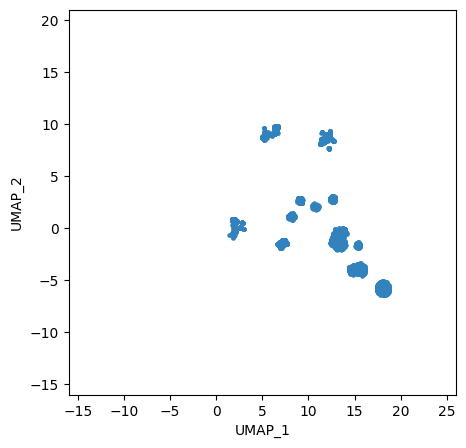

In [ ]:
# ORD-C
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(df_new.x, df_new.y, s=5, c='#3182bd')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.xlim(-16, 26)
plt.ylim(-16, 21)
plt.savefig('ord_c.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

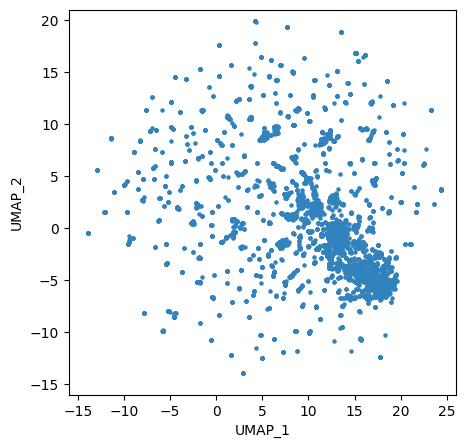

In [ ]:
# ORD-R
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(df_rand.x, df_rand.y, s=5, c='#3182bd')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.xlim(-16, 26)
plt.ylim(-16, 21)
plt.savefig('ord_r.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()